# Overview

### One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line. 

### Markdowns In this recruiting competition, job-seekers are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.

### More Information on https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview

## Content

### 1. Importing and Cleaning Data
### 2. EDA
### 3. Data Preparation for Model Training
### 4. Implementing Machine Learning Algo 
### 5. Hyperparameter Tuning
### 6. Comparision of Different models and Conclusion

## Importing and Cleaning Data

In [162]:
import pandas as pd
import numpy as np

# Import data

df_f = pd.read_csv("/Users/umashankarlath/Documents/UIUC/Project/Demand Forecasting /walmart-recruiting-store-sales-forecasting/features.csv")
df_st = pd.read_csv("/Users/umashankarlath/Documents/UIUC/Project/Demand Forecasting /walmart-recruiting-store-sales-forecasting/stores.csv")
df_train = pd.read_csv("/Users/umashankarlath/Documents/UIUC/Project/Demand Forecasting /walmart-recruiting-store-sales-forecasting/train.csv")
df_test = pd.read_csv("/Users/umashankarlath/Documents/UIUC/Project/Demand Forecasting /walmart-recruiting-store-sales-forecasting/test.csv")

# Convert date column into datetime
df_f["Date"] = pd.to_datetime(df_f["Date"])
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

In [163]:
# Merging test and train dataset
df_all_train = df_train.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_train = df_all_train.merge(df_st, how="left", on=["Store"])

df_all_test = df_test.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_test = df_all_test.merge(df_st, how="left", on=["Store"])


In [164]:
# Encoding True/False to binary values

df_all_train = df_all_train.applymap(lambda x: 1 if x == True else x)
df_all_train = df_all_train.applymap(lambda x: 0 if x == False else x)

df_all_test = df_all_test.applymap(lambda x: 1 if x == True else x)
df_all_test = df_all_test.applymap(lambda x: 0 if x == False else x)

In [165]:
#Replace NAN values in Temperature, fule price, CPI and unemployment column with averages. 
df_all_train[["Temperature"]] = df_all_train[["Temperature"]].fillna(df_all_train[["Temperature"]].mean())
df_all_train[["Fuel_Price"]] = df_all_train[["Fuel_Price"]].fillna(df_all_train[["Fuel_Price"]].mean())
df_all_train[["CPI"]] = df_all_train[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_train[["Unemployment"]] = df_all_train[["Unemployment"]].fillna(df_all_train[["Unemployment"]].mean())

df_all_test[["Temperature"]] = df_all_test[["Temperature"]].fillna(df_all_test[["Temperature"]].mean())
df_all_test[["Fuel_Price"]] = df_all_test[["Fuel_Price"]].fillna(df_all_test[["Fuel_Price"]].mean())
df_all_test[["CPI"]] = df_all_test[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_test[["Unemployment"]] = df_all_test[["Unemployment"]].fillna(df_all_test[["Unemployment"]].mean())

# Replace the NaN values with 0
df_all_train = df_all_train.fillna(0)
df_all_test = df_all_test.fillna(0)

In [166]:
# Hot Encoding

dum=pd.get_dummies(df_all_train['Type'], sparse=True)
df_all_train['Type A']=dum['A']
df_all_train['Type B']=dum['B']
df_all_train['Type C']=dum['C']

dum=pd.get_dummies(df_all_test['Type'], sparse=True)
df_all_test['Type A']=dum['A']
df_all_test['Type B']=dum['B']
df_all_test['Type C']=dum['C']

## EDA

### Correlation Heat Map


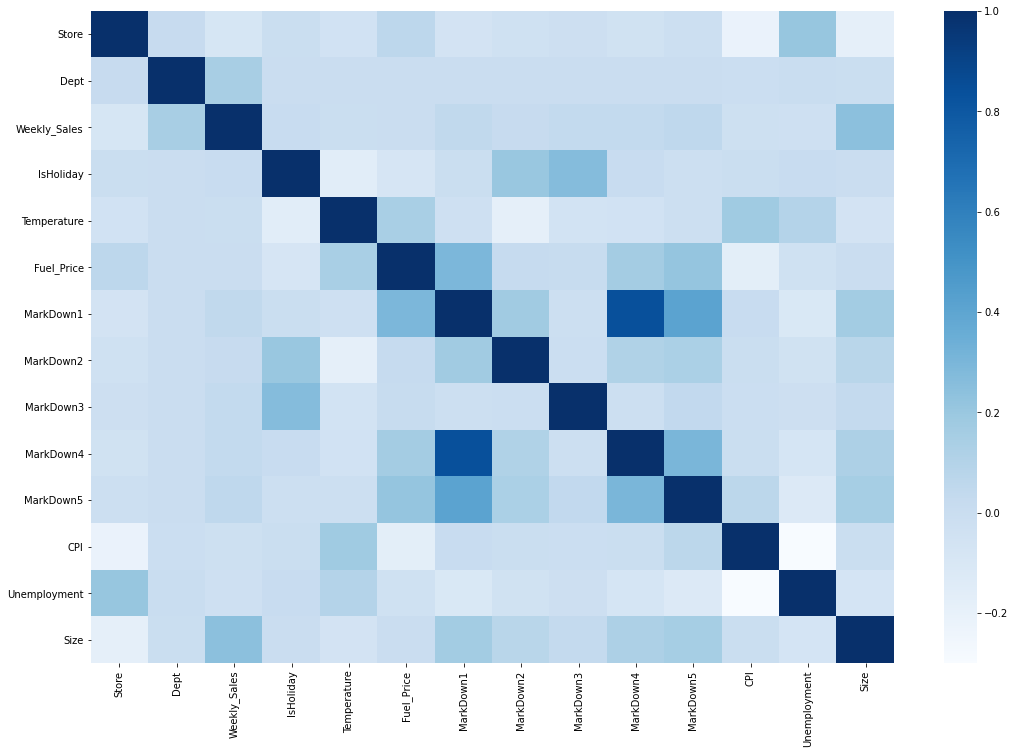

In [32]:
# Correlation Heat Map

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (18,12))

sns.heatmap(df_all_train.corr(),cmap="Blues")


#### Inferences -

#### 1. Department, Store size and Type have moderate correlation with the weekly sales
#### 2. Markdown1-5 have very weak correlation with the weekly sales, so we will leave these columns out
#### 3. Temperature. Fuel price, CPI and Unemployment are very weakly coorelated with the weekly sales, so these columns will also be dropped out


### Trend in Different features

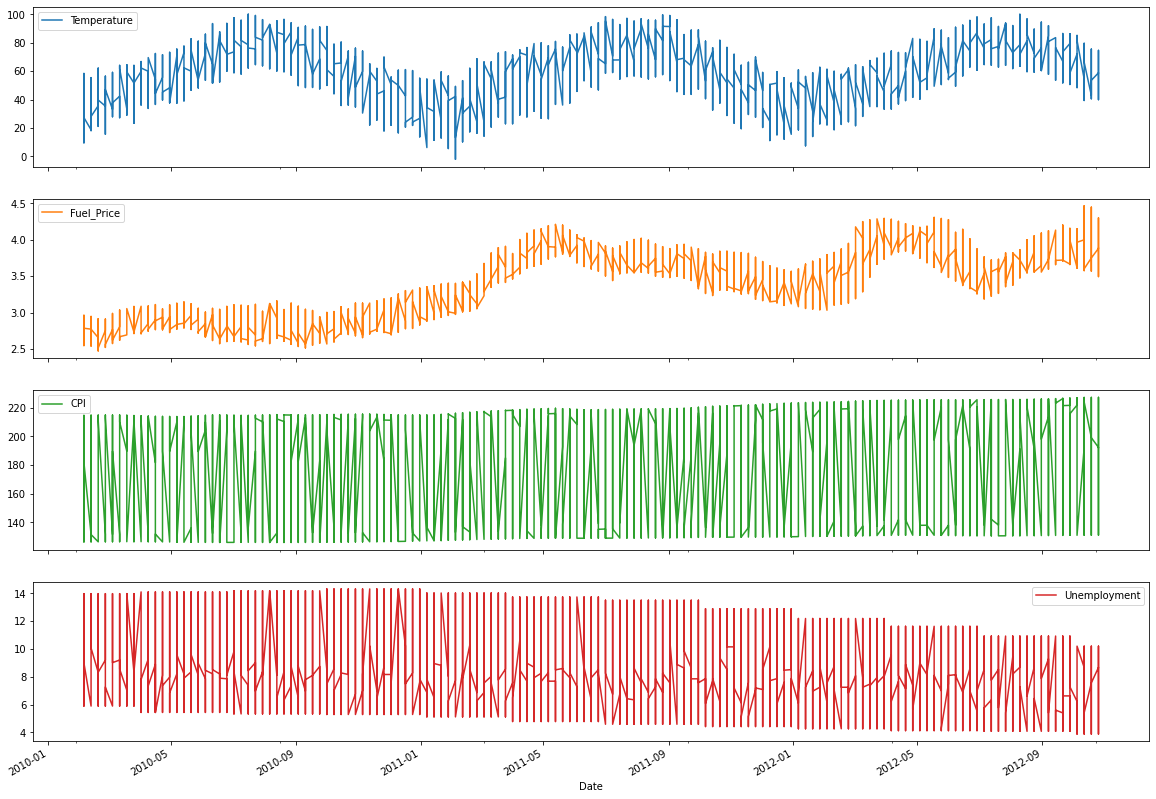

In [33]:
# Plots for the different features in the df: 
df_all_train[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

#### Inferences -

#### 1. Discounts: We have a few spikes, but not too many to make assumptions of the affects of it. 
#### 2. Temperature: it seems like it is decently seasonal, which is reasonable when we talk about temperature on a YoY basis.
#### 3. Fuel Price: Has a slight positive trend.
#### 4. Unemployment: Has a slight negative trend over this timeframe.

### Weakly Sales Plot

<function matplotlib.pyplot.show(*args, **kw)>

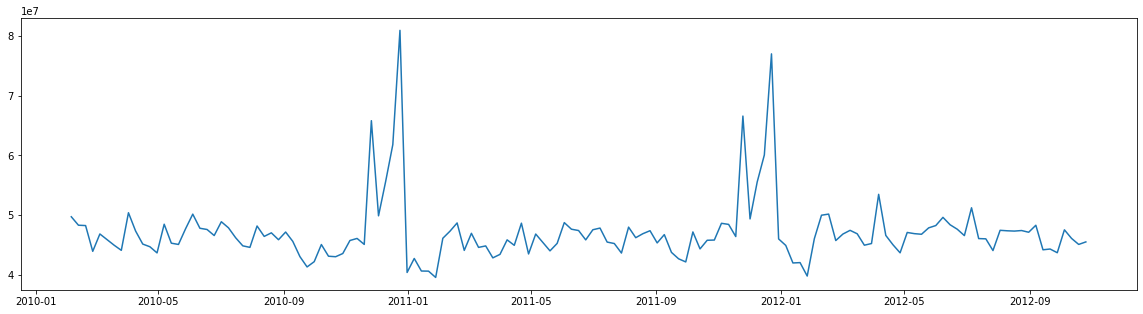

In [37]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = df_all_train.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.show

#### Inferences -

#### Peak in Demand - The end of December seems like a popular time to buy our company's specific products. 
#### Dip in Demand - Around the end of january it seems to be a pretty steep dip

### Relation between size of the store and sales

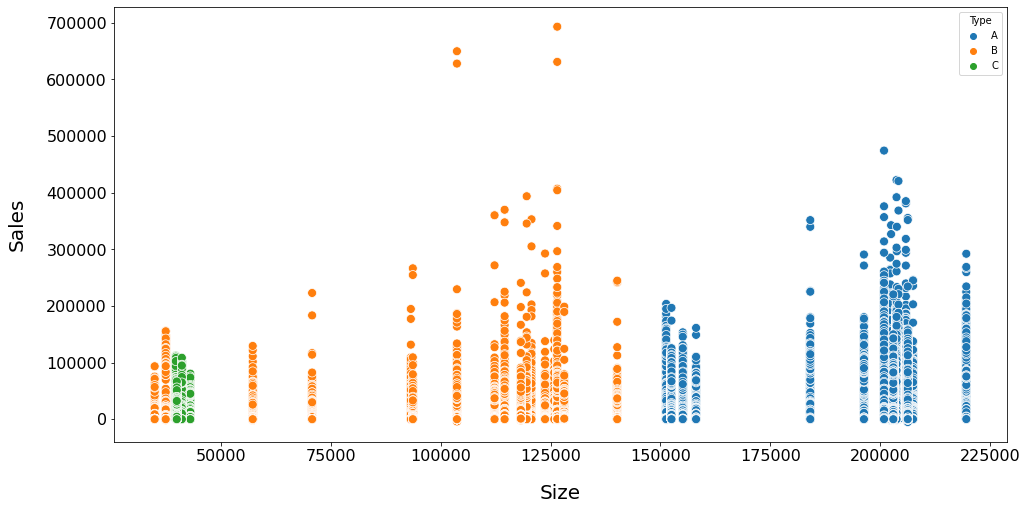

In [39]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=df_all_train.Size, y=df_all_train.Weekly_Sales, hue=df_all_train.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Inferences -

#### The size of the store shows a linear relationship with the weekly sales. 

### Relation between temperature and sales

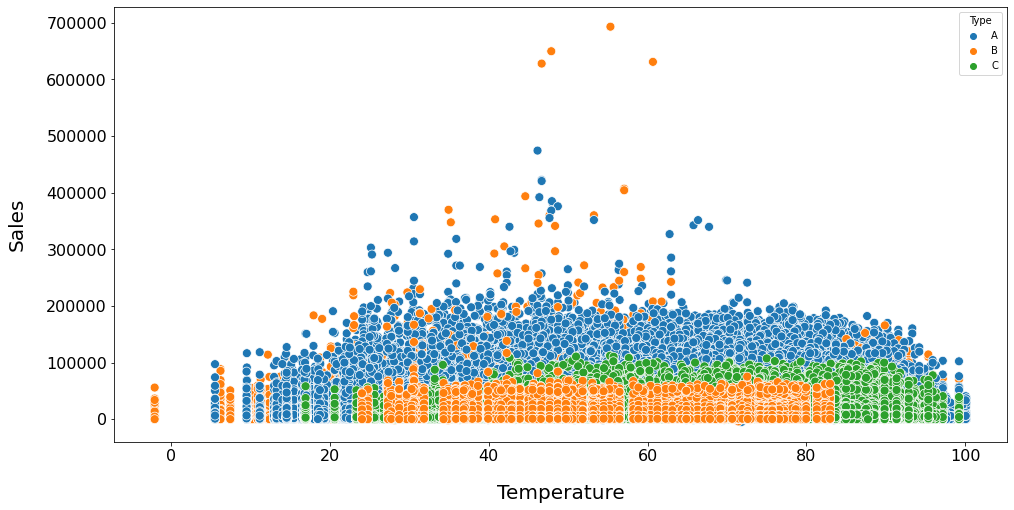

In [42]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=df_all_train.Temperature, y=df_all_train.Weekly_Sales, hue=df_all_train.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);


#### Inferences -

#### At low and very high temperatures the sales seems to dip a bit but in general there doesn't exist a clear relationship

### Relation between Fuel Price and sales

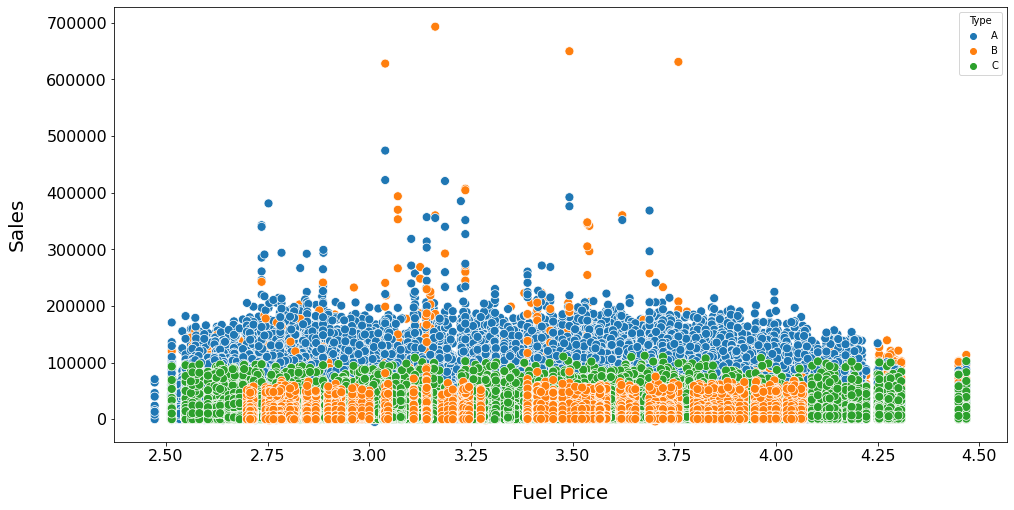

In [43]:

plt.figure(figsize=(16,8))
sns.scatterplot(x=df_all_train.Fuel_Price, y=df_all_train.Weekly_Sales, hue=df_all_train.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Fuel Price', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Inferences -
#### There doesn't exist a clear relationship

### Relation between Unemployment and sales

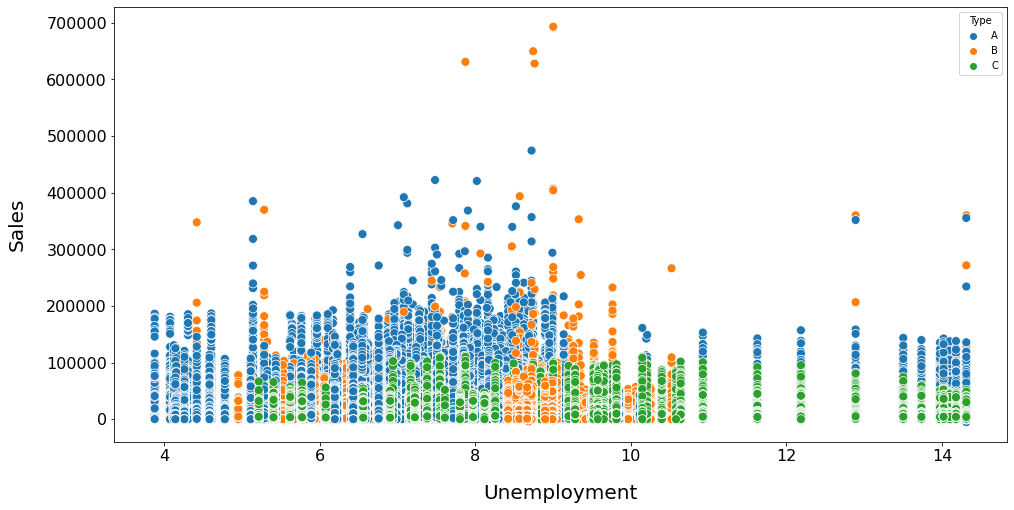

In [46]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=df_all_train.Unemployment, y=df_all_train.Weekly_Sales, hue=df_all_train.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Inferences -
#### There doesn't exist a clear relationship

## Data Preparation for Model Training

In [167]:
train_all = df_all_train

train_X = df_all_train.drop(["Weekly_Sales", 'Date', 'Type', 'Temperature','Fuel_Price', 'CPI', 'Unemployment'], axis=1)
train_y = train_all["Weekly_Sales"]
test_X = df_all_test 

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

## Implementing Machine Learning Algo

### Random Forest Regressor

In [168]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  96451071.75688474
RMSE:  9820.950654436909
R^2: 0.7336912630101704


### KNN

In [169]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  275415902.31274056
RMSE:  16595.65914065303
R^2: 0.23955576899450315


### Decision Tree Regressor

In [170]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  112286991.06030452
RMSE:  10596.555622479624
R^2: 0.689967086679641


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


### Extra Trees Regressor


In [184]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion="mse", max_depth=None,
                                      max_features="auto", max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=2, min_samples_split=5,
                                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
                                      oob_score=False, random_state=None, warm_start=False)
etr_random_best.fit(X_train, y_train)
y_pred = etr_random_best.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  66348002.13071403
RMSE:  8145.428296333719
R^2: 0.8168081253283974


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


### Linear Regression 

In [176]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

MSE:  331069119.84355223
RMSE:  18195.3048846001
R^2: 0.08589300713936843


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


### Lasso Regression

In [177]:
las = Lasso()
las.fit(X_train, y_train)
y_pred = las.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  331153980.2303852
RMSE:  18197.63666607247
R^2: 0.08565870116405572


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [174]:
X_train

,Store,Dept,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Type A,Type B,Type C
0,1,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,0
1,1,1,1,0.0,0.0,0.0,0.0,0.0,151315,1,0,0
2,1,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,0
3,1,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,0
4,1,1,0,0.0,0.0,0.0,0.0,0.0,151315,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
337251,35,58,0,0.0,0.0,0.0,0.0,0.0,103681,0,1,0
337252,35,58,0,0.0,0.0,0.0,0.0,0.0,103681,0,1,0
337253,35,58,0,0.0,0.0,0.0,0.0,0.0,103681,0,1,0
337254,35,58,0,0.0,0.0,0.0,0.0,0.0,103681,0,1,0


## Hyperparameter Tuning

In [200]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_leaf': [1, 5, 10], 'min_samples_split': [1, 5, 10],
              'n_estimators': [10, 100, 500]}

etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion="mse", max_depth=None,
                                      max_features="auto", max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_weight_fraction_leaf=0.0, n_jobs=1,
                                      oob_score=False, random_state=None, warm_start=False)

g_search = GridSearchCV(estimator = etr_random_best, param_grid = param_grid,
                        cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

g_search.fit(X_train, y_train);

print(g_search.best_params_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 859, in d

{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [201]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion="mse", max_depth=None,
                                      max_features="auto", max_leaf_nodes=None,
                                      min_impurity_decrease=0.0, min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=5,
                                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
                                      oob_score=False, random_state=None, warm_start=False)
etr_random_best.fit(X_train, y_train)
y_pred = etr_random_best.predict(X_test)

print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

score = r2_score(y_test, y_pred)
print("R^2:", score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MSE:  65884685.23566322
RMSE:  8116.938168771721
R^2: 0.8180873784761286


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


## Comparision of Different model and Conclusion

### Feature Importance

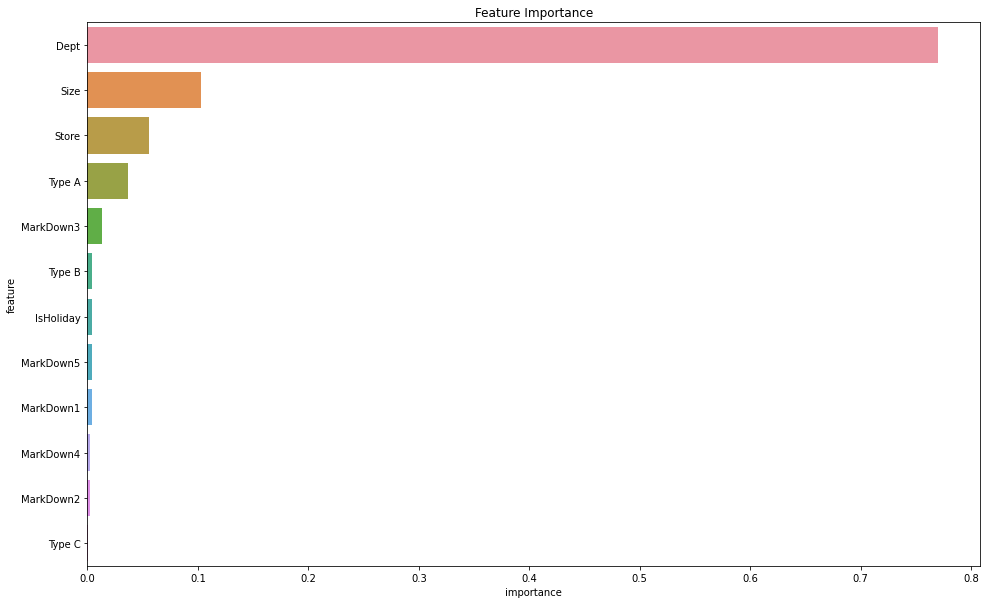

In [185]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': etr_random_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

### Lasso Regression - 
#### 1. MSE:  331153980.23
#### 2. RMSE:  18197.64
#### 3. R^2: 0.086


### Linear Regression - 
#### 1. MSE:  331069119.84
#### 2. RMSE:  18195.30
#### 3. R^2: 0.085


### Extra Trees Regressor - 
#### 1. MSE:  66367571.79
#### 2. RMSE:  8146.63
#### 3. R^2: 0.82

### Decision Tree Regressor - 
#### 1. MSE:  112286991.06
#### 2. RMSE:  10596.56
#### 3. R^2: 0.69


### KNN - 
#### 1. MSE:  275415902.31
#### 2. RMSE:  16595.65
#### 3. R^2: 0.24


### Random Forest Regressor - 
#### 1. MSE:  96451071.76
#### 2. RMSE:  9820.96
#### 3. R^2: 0.73


#### The best performer among all the  models is "Extra Trees Regressor" with tuned Hyperparameters